# Plot results of F-layer models

Our selection of models of the F-layer are executed via a command line program 
writing detailed output to files (one per model) and summary data to a CSV file.
This notebook generates the figures associated with these models.

In [2]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

import flayer
import feo_thermodynamics as feot
import earth_model
import layer_setup

In [2]:
# Read (and display) our summary data set
summary_file = pathlib.Path('/Users/andreww/Code/slurry_cases/light_blue/cases.csv')
summary_df = pd.read_csv(summary_file)
summary_df

,case,dt,dx,N2,dT_liq,dT_cond,total_latent_heat,total_o_rate,max_particle_radius
0,case_100.0_0.015,100.0,0.015000,6.922624e-08,3.848579,168.157535,2024.00918,0.000115,0.00135
1,case_100.0_0.014375,100.0,0.014375,6.555056e-08,0.383714,168.157535,0.00000,0.000000,0.00000
2,case_100.0_0.01375,100.0,0.013750,6.187642e-08,-3.078828,168.157535,NaN,NaN,NaN
3,case_100.0_0.013125,100.0,0.013125,5.820382e-08,-6.539055,168.157535,NaN,NaN,NaN
4,case_100.0_0.0125,100.0,0.012500,5.453276e-08,-9.996970,168.157535,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1039,case_-75.0_0.0,-75.0,0.000000,1.391984e-08,96.322228,-6.842465,NaN,NaN,NaN
1040,case_-75.0_-0.000625,-75.0,-0.000625,1.027548e-08,92.911675,-6.842465,NaN,NaN,NaN
1041,case_-75.0_-0.00125,-75.0,-0.001250,6.632639e-09,89.503323,-6.842465,NaN,NaN,NaN
1042,case_-75.0_-0.001875,-75.0,-0.001875,2.991314e-09,86.097167,-6.842465,NaN,NaN,NaN


In [13]:
def plot_summary_figure(results_df, fig=None, ax=None):
    """
    Create a plot showing the heat production as a function of layer setup
    
    The layer setup here amounts to two parameters, dx, the composition 
    difference from well mixed at the ICB and dt, the temperature
    difference from an adiabat at the ICB. We filter (and show) models
    that are not viabale on the basis of being too hot (above the
    liquidus at the ICB), too cold (below the temperature at the top
    of the F-layer at the ICB), or not statified (imaginary N_BV).
    """
    if (fig is None) != (ax is None):
        raise ValueError("Must specify both fig and ax or have them both created.")
    if (fig is None) and (ax is None):
        fig, ax = plt.subplots(figsize=(7,6))
        
    point_scale = 400
    
    # Filter inputd data...
    # snow_df is only the cases where we ran a snow calc
    snow_df = results_df[~results_df["total_latent_heat"].isna()]
    # unstable_df is all the cases where the liquid is not stratified
    unstable_df = results_df[results_df["N2"] < 0.0]
    # Wrong dtdr is too cold (colder at the bottom than the top)
    wrong_dtdr_df = results_df[results_df["dT_cond"] < 0.0]
    # melting_df is above liquidus at ICB
    melting_df = results_df[results_df["dT_liq"] < 0.0]
     
    ax.axhline(c='k', lw=0.5, zorder=0)
    ax.axvline(c='k', lw=0.5, zorder=0)
    ax.scatter(unstable_df["dx"], unstable_df["dt"], s=40, facecolors='none', edgecolors='k')
    ax.scatter(wrong_dtdr_df["dx"], wrong_dtdr_df["dt"], s=15, facecolors='none', edgecolors='b')
    ax.scatter(melting_df["dx"], melting_df["dt"], s=15, facecolors='none', edgecolors='r')
    c = ax.scatter(snow_df["dx"], snow_df["dt"], c=np.array(snow_df["total_latent_heat"])/1.0E12,
                  norm=colors.Normalize(vmin=0.0, vmax=34), cmap='viridis',
                  s=snow_df["max_particle_radius"]*point_scale)  
    ax.set_ylabel("$\Delta T_{ICB}$")
    ax.set_xlabel("$\Delta X_{ICB}$")

    ax.set_xlim(-0.003, 0.0155)
    ax.set_ylim(-80, 105)
    fig.colorbar(c, label='Latent heat from snow (TW)', extend='max', location='right',
                 shrink=0.5, anchor=(0.0,0.9))
    
    # Size scale
    ax.scatter(0.0165, -20, s=0.001*point_scale, c='k', clip_on=False)
    ax.text(0.0175, -20, "1 mm")
    ax.scatter(0.0165, -30, s=0.01*point_scale, c='k', clip_on=False)
    ax.text(0.0175, -30, "1 cm")
    ax.scatter(0.0165, -40, s=0.1*point_scale, c='k', clip_on=False)
    ax.text(0.0175, -40, "10 cm")
    ax.scatter(0.0165, -50, s=1.0*point_scale, c='k', clip_on=False)
    ax.text(0.0175, -50, "1 m")
    
    # Why do the squares need to be offset?
    ax.plot(0.009987, 50.1, marker='s', markerfacecolor='none', markeredgecolor='green', ms=np.sqrt(0.15*point_scale))
    ax.plot(-0.000626, -24.8, marker='D', markerfacecolor='none', markeredgecolor='green', ms=np.sqrt(0.15*point_scale))
    
    plt.show()

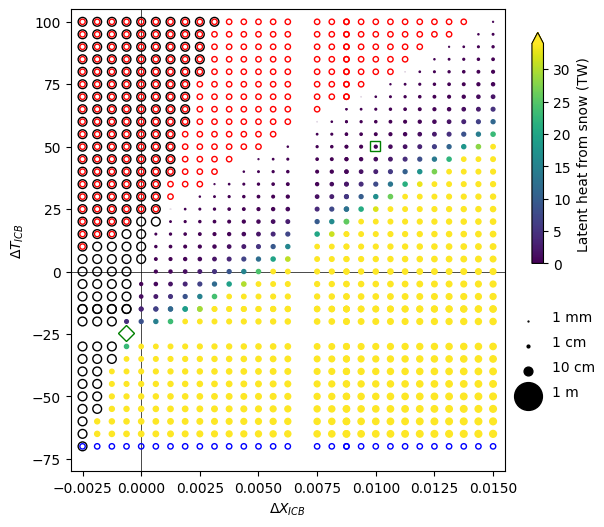

In [14]:
summary_file = pathlib.Path('/Users/andreww/Code/slurry_cases/tx_grid/grid.csv')
summary_df_hetro = pd.read_csv(summary_file)
plot_summary_figure(summary_df_hetro)

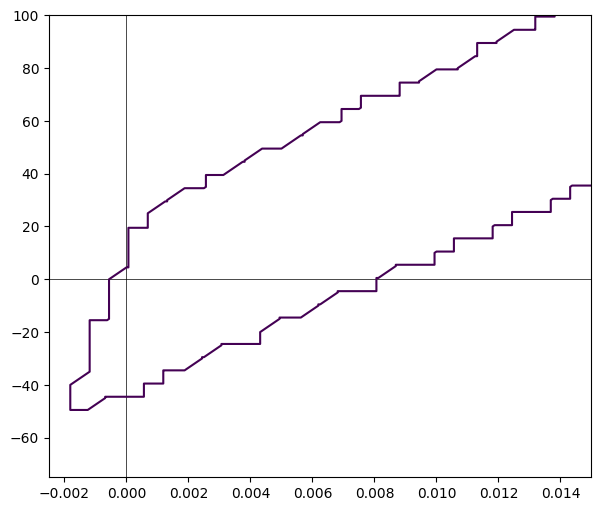

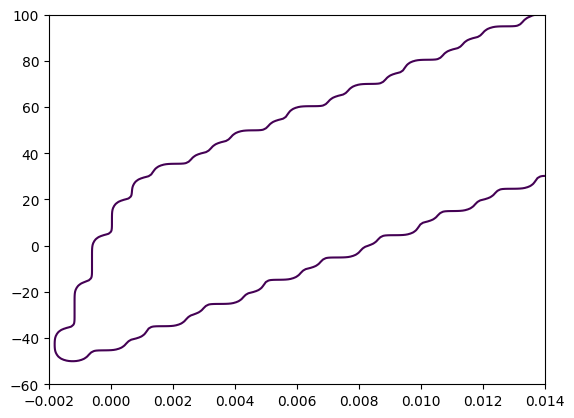

In [10]:
import scipy as sp

def plot_valid_locus(results_df, fig=None, ax=None):
    """
    Create a plot showing the locus of 'valid' results
    
    """
    if (fig is None) != (ax is None):
        raise ValueError("Must specify both fig and ax or have them both created.")
    if (fig is None) and (ax is None):
        fig, ax = plt.subplots(figsize=(7,6))
    
    
    #snow_df = results_df[~results_df["total_latent_heat"].isna()]
    #valid_df = snow_df[snow_df["total_latent_heat"]/1.0E12 < 34.0]
    
    plot_df = results_df.copy(deep=True)
    plot_df['valid'] = np.where(plot_df["total_latent_heat"]/1.0E12 < 34.0, 10.0, 0.0)
    
    ax.axhline(c='k', lw=0.5, zorder=0)
    ax.axvline(c='k', lw=0.5, zorder=0)
    #ax.scatter(plot_df["dx"], plot_df["dt"], c=plot_df['valid'])

    ax.tricontour(plot_df["dx"], plot_df["dt"], plot_df['valid'], levels=[1.0])
    plt.show()
    
    # Interpolate onto regular grid
    grid_x, grid_y = np.mgrid[-0.002:0.014:200j, -60:100:200j]
    grid_z = sp.interpolate.griddata((plot_df["dx"], plot_df["dt"]), plot_df['valid'], 
                                     (grid_x, grid_y), method='nearest')
    
    # Gaussian filter to get rid of holes and smooth the edges
    grid_z = sp.ndimage.gaussian_filter(grid_z, 2.5)
    # Plot validity bounds (10 okay, 0 not okay)
    plt.contour(grid_x, grid_y, grid_z, levels=[1.0])
    
plot_valid_locus(summary_df)

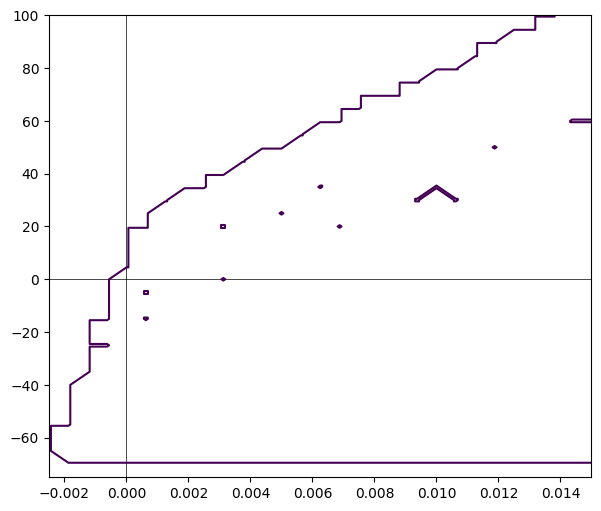

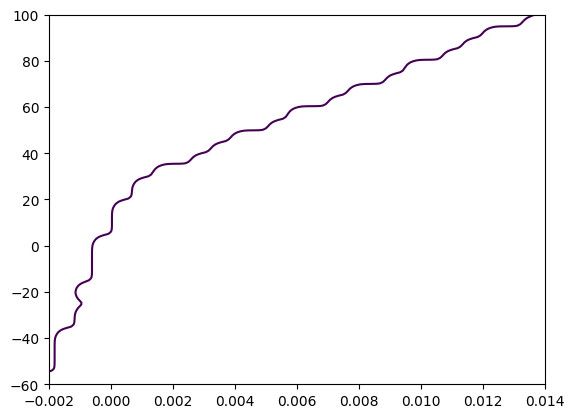

In [11]:
plot_valid_locus(summary_df2)

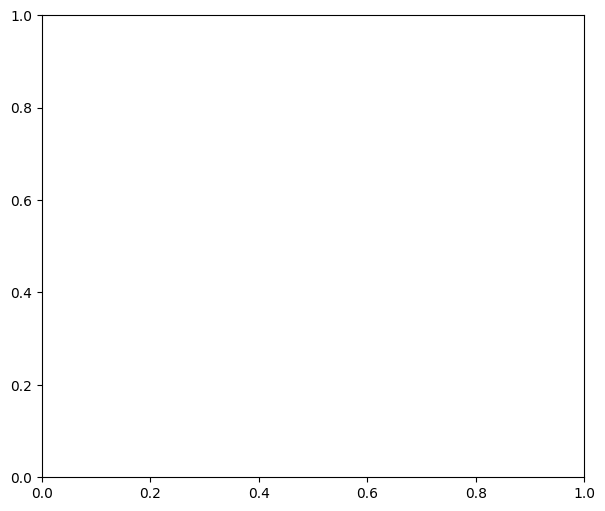

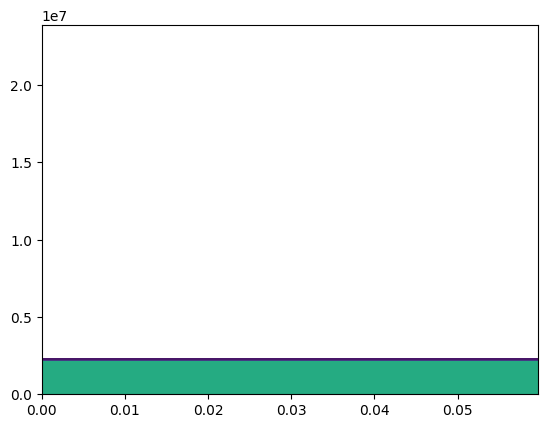

In [12]:
def plot_key_outputs(results_df, fig=None, ax=None):
    """
    Create a plot showing the locus of 'valid' results
    
    """
    if (fig is None) != (ax is None):
        raise ValueError("Must specify both fig and ax or have them both created.")
    if (fig is None) and (ax is None):
        fig, ax = plt.subplots(figsize=(7,6))
    
    
    #snow_df = results_df[~results_df["total_latent_heat"].isna()]
    #valid_df = snow_df[snow_df["total_latent_heat"]/1.0E12 < 34.0]
    
    plot_df = results_df.copy(deep=True)
    plot_df['valid'] = np.where(plot_df["total_latent_heat"]/1.0E12 < 34.0, 10.0, 0.0)
    
    ax.axhline(c='k', lw=0.5, zorder=0)
    ax.axvline(c='k', lw=0.5, zorder=0)
    #ax.scatter(plot_df["dx"], plot_df["dt"], c=plot_df['valid'])

    #ax.tricontour(plot_df["max_particle_radius"], plot_df["total_o_rate"], plot_df['valid'], levels=[1.0])
    plt.show()
    
    # Interpolate onto regular grid
    grid_x, grid_y = np.mgrid[0.0:plot_df["max_particle_radius"].max():200j, 0:plot_df["total_o_rate"].max():200j]
    grid_z = sp.interpolate.griddata((plot_df["max_particle_radius"].fillna(0), plot_df["total_o_rate"].fillna(0)), plot_df['valid'], 
                                     (grid_x, grid_y), method='nearest')
    
    # Gaussian filter to get rid of holes and smooth the edges
    grid_z = sp.ndimage.gaussian_filter(grid_z, 2.5)
    # Plot validity bounds (10 okay, 0 not okay)
    plt.contourf(grid_x, grid_y, grid_z, levels=[1.0, 2.0, 3.0, 10.0])
    
plot_key_outputs(summary_df)


In [13]:
summary_df["total_o_rate"].max()

23914675.20379293

In [14]:
summary_df["total_o_rate"].min()

0.0

In [5]:
def plot_lines(data, fig=None, ax=None):
    """
    Function to plot lines in solid-fraction nuc rate space
    
    needs a list of data frames
    """
    if (fig is None) != (ax is None):
        raise ValueError("Must specify both fig and ax or have them both created.")
    if (fig is None) and (ax is None):
        fig, ax = plt.subplots(figsize=(7,6))
     
    point_scale = 400
        
    for item in data:
        df = item["df"]
        c = ax.scatter(df["max_nucleation_rate"], df["max_solid_volume_fraction"], 
                       c=np.array(df["total_latent_heat"])/1.0E12,
                       norm=colors.Normalize(vmin=0.0, vmax=34), cmap='viridis',
                       s=df["max_particle_radius"]*point_scale)
        
    
        ax.plot(df.iloc[0]["max_nucleation_rate"], df.iloc[0]["max_solid_volume_fraction"], 
                marker=item["m"], markerfacecolor='none', markeredgecolor=item["color"],
                ms=np.sqrt(0.15*point_scale))
        
    ax.set_ylabel("Solid fraction")
    ax.set_yscale("log")
    ax.set_xlabel("Nucleation rate (m$^{-3}$s$^{-1}$)")
    ax.set_xscale("log")

    #ax.set_xlim(0.8E-15, 2.0E-6)
    #ax.set_ylim(-80, 105)
    fig.colorbar(c, label='Latent heat from snow (TW)', extend='max', location='right',
                 shrink=0.5, anchor=(0.0,0.9))
    
    # Size scale
    ax.scatter(0.8E-5, 1.0E-13, s=0.001*point_scale, c='k', clip_on=False)
    ax.text(2.0E-5, 1.0E-13, "1 mm")
    ax.scatter(0.8E-5, 1.0E-14, s=0.01*point_scale, c='k', clip_on=False)
    ax.text(2.0E-5, 1.0E-14, "1 cm")
    ax.scatter(0.8E-5, 1.0E-15, s=0.1*point_scale, c='k', clip_on=False)
    ax.text(2.0E-5, 1.0E-15, "10 cm")
    ax.scatter(0.8E-5, 1.0E-16, s=1.0*point_scale, c='k', clip_on=False)
    ax.text(2.0E-5, 1.0E-16, "1 m")
    
    # Why do the squares need to be offset?
    #ax.plot(0.009987, 40.1, marker='s', markerfacecolor='none', markeredgecolor='green', ms=np.sqrt(0.15*point_scale))
    #ax.plot(-0.000626, -24.8, marker='D', markerfacecolor='none', markeredgecolor='green', ms=np.sqrt(0.15*point_scale))
    
    plt.show()

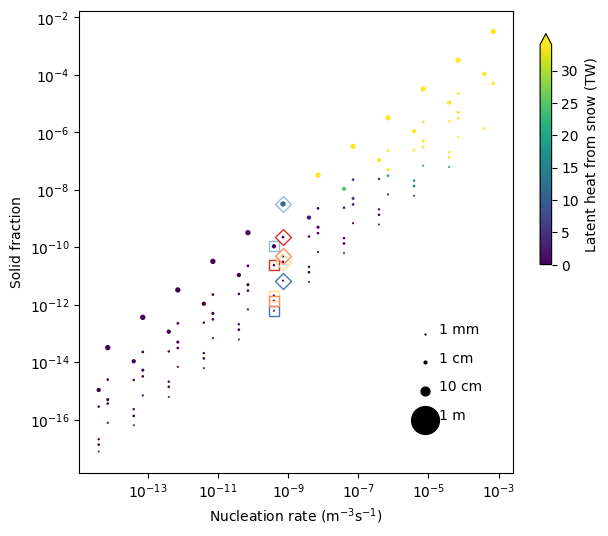

In [6]:
red = '#d73027'
orange = '#fc8d59'
yellow = '#fee090'
light_blue = '#91bfdb'
dark_blue = '#4575b4'

base_dir = '/Users/andreww/Code/slurry_cases'

data = [{'file': 'nuc_scan_1/yellow/scan.csv', 
         'color': yellow, 'm': 's'},
        {'file': 'nuc_scan_1/light_blue/scan.csv',
         'color': light_blue, 'm': 's'},
        {'file': 'nuc_scan_1/dark_blue/scan.csv',
         'color': dark_blue, 'm': 's'},
        {'file': 'nuc_scan_1/orange/scan.csv',
         'color': orange, 'm': 's'},
        {'file': 'nuc_scan_1/red/scan.csv',
         'color': red, 'm': 's'},
        {'file': 'nuc_scan_2/yellow/scan.csv',
         'color': yellow, 'm': 'D'},
        {'file': 'nuc_scan_2/light_blue/scan.csv',
         'color': light_blue, 'm': 'D'},
        {'file': 'nuc_scan_2/dark_blue/scan.csv',
         'color': dark_blue, 'm': 'D'},
        {'file': 'nuc_scan_2/orange/scan.csv',
         'color': orange, 'm': 'D'},
        {'file': 'nuc_scan_2/red/scan.csv',
         'color': red, 'm': 'D'}]

for item in data:
    filep = pathlib.Path(base_dir)/item["file"]
    df = pd.read_csv(filep)
    item["df"] = df   
    
plot_lines(data)


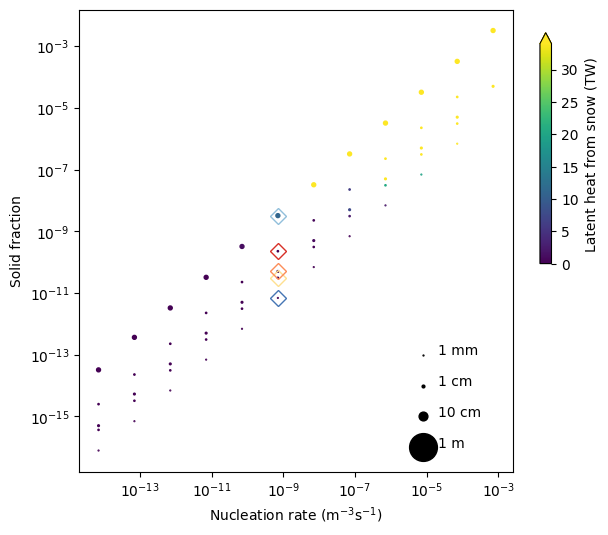

In [9]:
red = '#d73027'
orange = '#fc8d59'
yellow = '#fee090'
light_blue = '#91bfdb'
dark_blue = '#4575b4'

base_dir = '/Users/andreww/Code/slurry_cases'

data = [{'file': 'nuc_scan_2/yellow/scan.csv',
         'color': yellow, 'm': 'D'},
        {'file': 'nuc_scan_2/light_blue/scan.csv',
         'color': light_blue, 'm': 'D'},
        {'file': 'nuc_scan_2/dark_blue/scan.csv',
         'color': dark_blue, 'm': 'D'},
        {'file': 'nuc_scan_2/orange/scan.csv',
         'color': orange, 'm': 'D'},
        {'file': 'nuc_scan_2/red/scan.csv',
         'color': red, 'm': 'D'}]

for item in data:
    filep = pathlib.Path(base_dir)/item["file"]
    df = pd.read_csv(filep)
    item["df"] = df   
    
plot_lines(data)